# V01 - Proyecto Parte 2

En esta parte del proyecto se continuará con una actualización del 'Proyecto Parte 1', agregando correcciones, mejoras o simples actualizaciones. Este proyecto se dividirá en las siguientes secciones:

## **Puesta al día**

Se volverán a cargar los datos y se realizarán todos los pasos de transformación aplicados en la Parte 1, sin detallar el proceso (ya fue explicado en 'Proyecto Parte 1'):

- **Paso 1:** Transformación de la zona horaria.
    - Agregación de características ('Hour', 'Minute', 'DayOfYear').
- **Paso 2:** Descarte del primer y último día.
- **Paso 3:** Ingeniería de características (Dos DataFrames: 'Buys' y 'Sells', con una nueva característica en cada uno ('Tres')).
    - Actualización de la función que agrega las operaciones, ahora 'Tres', 'Dos' o 'PuntoCinco', según se seleccione en los parámetros.
- **Paso 4:** Descarte de observaciones registradas desde las 15:00 horas hasta las 24:00 (Buys-Sells).
- **Paso 5:** Guardar el DataFrame actualizado en formato .csv

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## **Continuación**

Inicio del **Proyecto Parte 2**.

### **Transformación de Datos**

**Ingeniería de Datos**  
Se agregarán y descartarán características con el objetivo de acercarnos a un dataset más fiel a la variable objetivo ('Tres').  
Para esto seguiremos los siguientes pasos:  
- Cargamos el dataset 'Buy' (trabajaremos solo con este por el momento).
- Agregamos como nueva característica al set de datos los siguientes indicadores técnicos:
    - Average True Range de período 14
    - RSI 
- Agregamos una nueva característica llamada ('máximo', 'mínimo') (si la vela es un máximo o mínimo).
- Se guarda el nuevo conjunto de datos como archivos nuevos .csv (Buys_t, Sells_t).

### **Muestreo y equilibrio de datos**
(De aquí en adelante se trabajará el archivo V02.ipynb)
- Se crearán las secuencias para el entrenamiento y se revisará el desbalance de clases.
    - Se tomará la cuarta parte del dataset de entrenamiento para verificar que el modelo esté aprendiendo.
- Se dividirán las secuencias en conjunto de entrenamiento y validación.

### Actualizaciones

- No se incluirán las columnas de operaciones 'Dos' y 'PuntoCinco' (nos concentraremos en 'Tres').


### PUESTA AL DÍA

Librearias globales

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
#------------------------------------------------------------------------------------------------------------------
#| Esta celda solo se debe ejecutar si es la primera vez que se revisa este proyecto, sino, pasar a la siguiente. |
#------------------------------------------------------------------------------------------------------------------

#Load data
'''data=pd.read_csv('../Datos/US30.cash_data_m1_antiguo.csv',index_col=0,parse_dates=True)
#-----------------------------------------PASO 1-----------------------------------------

data.index=data.index.tz_localize('Etc/GMT-3')#Localizamos el horario en el que se encuentran los datos en MetaTrader5
data.index=data.index.tz_convert('Etc/GMT+5').tz_localize(None)# Al final eliminamos la zona horaria del índice

data['Year'] = data.index.year#Creamos una columna con el año del índice
data['DayOfYear'] = data.index.dayofyear#Creamos una columna con el dia del año del índice
data['Hour']=data.index.hour#Creamos una columna con la hora del índice
data['Minute']=data.index.minute#Creamos una columna con los minutos del índice

#-----------------------------------------PASO 2-----------------------------------------
data = data[~data['DayOfYear'].isin([data['DayOfYear'].min(),
                                     data['DayOfYear'].max()])]

#-----------------------------------------PASO 3-----------------------------------------

# Al solo procesar las columnas seleccionadas, la función optimiza el rendimiento, especialmente útil para DataFrames grandes.
def agregar_columnas_operaciones(df, Tres=False, Dos=False, PuntoCinco=False):
    """
    Agrega columnas de operaciones al DataFrame basado en los parámetros seleccionados.

    Parámetros:
    - df (pd.DataFrame): DataFrame original que contiene las columnas necesarias.
    - Tres (bool): Si es True, agrega y calcula la columna 'Tres'.
    - Dos (bool): Si es True, agrega y calcula la columna 'Dos'.
    - PuntoCinco (bool): Si es True, agrega y calcula la columna 'PuntoCinco'.

    Retorna:
    - pd.DataFrame: DataFrame con las nuevas columnas agregadas según los parámetros.
    """
    
    # Asegurarse de que el DataFrame esté ordenado cronológicamente
    df = df.sort_values(by=['DayOfYear', 'Hour', 'Minute']).reset_index(drop=True)
    
    # Inicializar las nuevas columnas con NaN según los parámetros
    columnas_a_agregar = {}
    if Tres:
        df['Tres'] = np.nan
        columnas_a_agregar['Tres'] = 3
    if Dos:
        df['Dos'] = np.nan
        columnas_a_agregar['Dos'] = 2
    if PuntoCinco:
        df['PuntoCinco'] = np.nan
        columnas_a_agregar['PuntoCinco'] = 1.5
    
    # Si no se seleccionó ninguna columna, retornar el DataFrame original
    if not columnas_a_agregar:
        print("No se seleccionó ninguna columna para agregar.")
        return df
    
    # Definir los factores de multiplicación para las columnas seleccionadas
    factores = columnas_a_agregar
    
    # Convertir las columnas de tiempo a minutos totales para facilitar cálculos
    df['TotalMinutes'] = df['DayOfYear'] * 1440 + df['Hour'] * 60 + df['Minute']
    
    n = len(df)
    
    # Iterar sobre cada fila del DataFrame
    for i in range(n):
        buy = df.at[i, 'Buy']
        open_price = df.at[i, 'open']
        day = df.at[i, 'DayOfYear']
        time = df.at[i, 'TotalMinutes']
        
        # Parámetros fijos
        StopLoss = 30
        
        # Para cada columna a calcular
        for col, factor in factores.items():
            if pd.notna(df.at[i, col]):
                continue  # Ya procesado
            
            # Calcular SL_price y TP_price
            if buy == 1:
                SL_price = open_price - StopLoss
                TP_price = open_price + StopLoss * factor
            else:
                SL_price = open_price + StopLoss
                TP_price = open_price - StopLoss * factor
            
            # Buscar en las observaciones siguientes
            j = i + 1
            operacion_cerrada = False
            while j < n:
                # Verificar cambio de día o tiempo máximo de 60 minutos
                current_day = df.at[j, 'DayOfYear']
                current_time = df.at[j, 'TotalMinutes']
                elapsed_time = current_time - time
                if current_day != day or elapsed_time >= 60:
                    # Operación cerrada por tiempo, se considera pérdida
                    df.at[i, col] = 0
                    operacion_cerrada = True
                    break
                
                high = df.at[j, 'high']
                low = df.at[j, 'low']
                
                if buy == 1:
                    if high >= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif low <= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                else:
                    if low <= TP_price:
                        df.at[i, col] = 1  # Ganó
                        operacion_cerrada = True
                        break
                    elif high >= SL_price:
                        df.at[i, col] = 0  # Perdió
                        operacion_cerrada = True
                        break
                j += 1
            
            if not operacion_cerrada:
                # Si no se cerró la operación dentro del DataFrame, se considera pérdida
                df.at[i, col] = 0
    
    # Eliminar la columna temporal 'TotalMinutes'
    df.drop(columns=['TotalMinutes'], inplace=True)
    
    return df

data=data[~data['Hour'].isin(list(range(16,24)))].copy() #Eliminamos los datos de las 16hs en adelante )
# Creamos los DataFrames de Buys y Sells
Buys=data.copy()
Sells=data.copy()
Buys['Buy']=1
Sells['Buy']=0
Buys = agregar_columnas_operaciones(Buys,True)#Agregamos las columnas de operaciones
Sells = agregar_columnas_operaciones(Sells,True)

#-----------------------------------------PASO 4-----------------------------------------

Buys=Buys[~Buys['Hour'].isin(list(range(15,24)))].copy() #Eliminamos los datos de las 15hs en adelante
Sells=Sells[~Sells['Hour'].isin(list(range(15,24)))].copy() #Eliminamos los datos de las 15hs en adelante

#-----------------------------------------PASO 5-----------------------------------------

Buys.to_csv('Buys.csv', index=False)#Guardamos los datos en un archivo csv
Sells.to_csv('Sells.csv', index=False)'''

### TRANSFORMACIÓN DE LOS DATOS

***INGENIERÍA DE DATOS***

In [29]:
Buys= pd.read_csv('Buys.csv') #Cargamos los dato y en el futuro Sells
Sells= pd.read_csv('Sells.csv') #Cargamos los dato y en el futuro Sells

Necesitamos descartar o agregar columnas caracteristicas, primero vamo a desacartar, vamo a analizar brevemente si las columnas que tenemos tienen alguna relación con la varibale objetivo.  
Notemos en el grafico de abajo que no parece haber una relación entre las caracteristicas **'spread'**, **'real_volume'** y **'Minute'**, sin embargo en **'tick_volume'** se muestra que las operaciones exitosas, generalmente contienen un valor de **'tick_volume'** mayor y **'Hour'** muestra que la mayoría de las operaciones ganadoras fueron abiertas desde las 6 am en adelante.  
Acciones a tomar:
- Descartamos las caracteristicas 'spread' y 'real_volume'
- No incluir 'Minute' como caracteristica en el entrenamiento. (no se elimnará ya que puede ser durante el procesamiento de los datos)

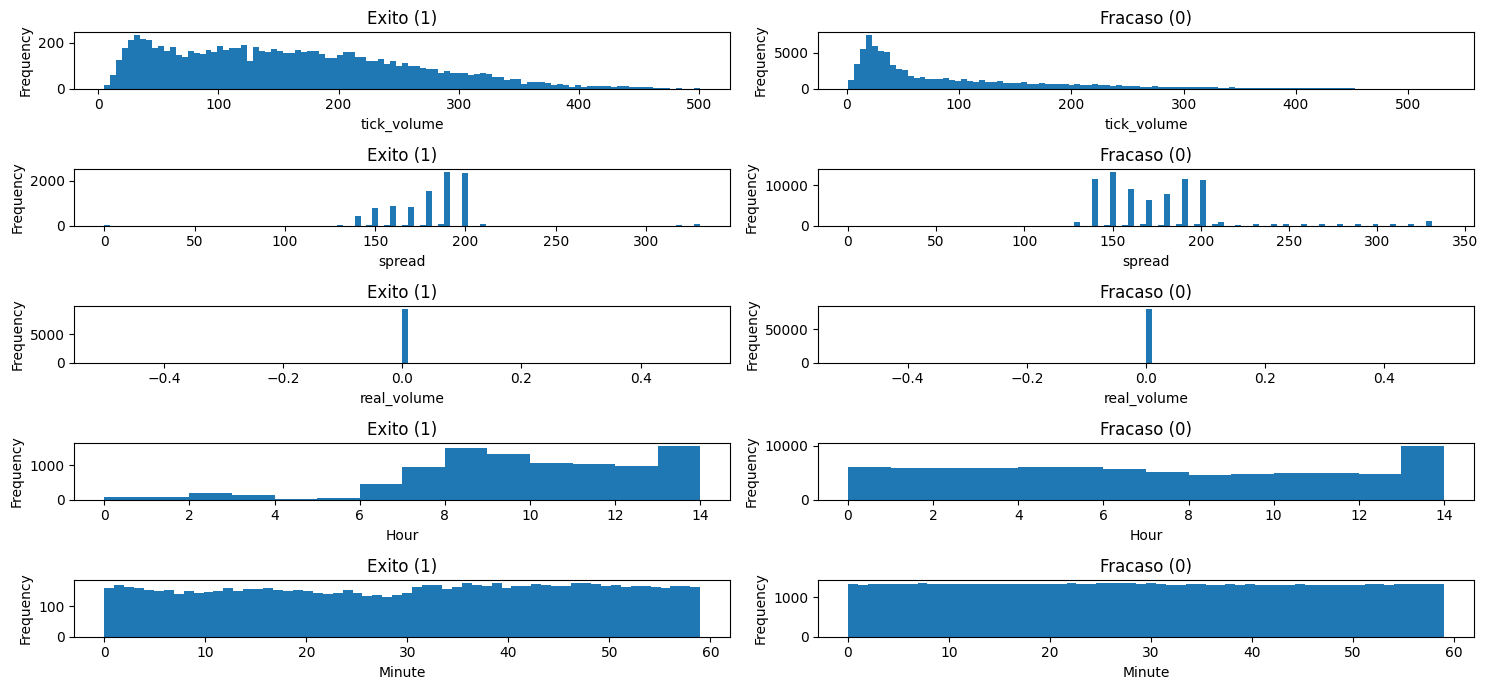

In [12]:
#-----------------------------------------ANALIZAMOS 'tick_volume'-----------------------------------------
fig,ax=plt.subplots(5,2,figsize=(15,7))
Unos=Buys[Buys['Tres']==1]['tick_volume'].plot(kind='hist',bins=100,ax=ax[0,0])
ax[0,0].set_title('Exito (1)')
ax[0,0].set_xlabel('tick_volume')
Ceros=Buys[Buys['Tres']==0]['tick_volume'].plot(kind='hist',bins=100,ax=ax[0,1])
ax[0,1].set_title('Fracaso (0)')
ax[0,1].set_xlabel('tick_volume')
#-----------------------------------------ANALIZAMOS 'spread'-----------------------------------------
Unos=Buys[Buys['Tres']==1]['spread'].plot(kind='hist',bins=100,ax=ax[1,0])
ax[1,0].set_title('Exito (1)')
ax[1,0].set_xlabel('spread')
Ceros=Buys[Buys['Tres']==0]['spread'].plot(kind='hist',bins=100,ax=ax[1,1])
ax[1,1].set_title('Fracaso (0)')
ax[1,1].set_xlabel('spread')
#-----------------------------------------ANALIZAMOS 'volume'-----------------------------------------
Unos=Buys[Buys['Tres']==1]['real_volume'].plot(kind='hist',bins=100,ax=ax[2,0])
ax[2,0].set_title('Exito (1)')
ax[2,0].set_xlabel('real_volume')
Ceros=Buys[Buys['Tres']==0]['real_volume'].plot(kind='hist',bins=100,ax=ax[2,1])
ax[2,1].set_title('Fracaso (0)')
ax[2,1].set_xlabel('real_volume')
#-----------------------------------------ANALIZAMOS 'Hour'-----------------------------------------
Unos=Buys[Buys['Tres']==1]['Hour'].plot(kind='hist',bins=14,ax=ax[3,0])
ax[3,0].set_title('Exito (1)')
ax[3,0].set_xlabel('Hour')
Ceros=Buys[Buys['Tres']==0]['Hour'].plot(kind='hist',bins=14,ax=ax[3,1])
ax[3,1].set_title('Fracaso (0)')
ax[3,1].set_xlabel('Hour')
#-----------------------------------------ANALIZAMOS 'Minute'-----------------------------------------
Unos=Buys[Buys['Tres']==1]['Minute'].plot(kind='hist',bins=60,ax=ax[4,0])
ax[4,0].set_title('Exito (1)')
ax[4,0].set_xlabel('Minute')
Ceros=Buys[Buys['Tres']==0]['Minute'].plot(kind='hist',bins=60,ax=ax[4,1])
ax[4,1].set_title('Fracaso (0)')
ax[4,1].set_xlabel('Minute')

plt.tight_layout()
plt.show()

In [30]:
Buys=Buys.drop(['spread','real_volume','Year','Buy'],axis=1).copy() #Eliminamos las columnas que no necesitamos
Sells=Sells.drop(['spread','real_volume','Year','Buy'],axis=1).copy() #Eliminamos las columnas que no necesitamos

Agregamos RSI y ATR

In [31]:
def agregar_atr_rsi(df, periodo_atr, periodo_rsi):
    """
    Agrega columnas ATR y RSI al DataFrame, calculadas por día del año.

    Parámetros:
    - df: pandas DataFrame con columnas ['open', 'high', 'low', 'close', 'tick_volume', 
                                         'DayOfYear', 'Hour', 'Minute', 'Tres']
    - periodo_atr: int, el período para calcular el ATR
    - periodo_rsi: int, el período para calcular el RSI

    Retorna:
    - pandas DataFrame con nuevas columnas 'ATR{periodo_atr}' y 'RSI{periodo_rsi}'
    """
    # Asegurar que el DataFrame está ordenado correctamente
    df = df.sort_values(['DayOfYear', 'Hour', 'Minute', 'Tres']).reset_index(drop=True)

    ### Cálculo del ATR ###

    # Calcular el Close anterior por día
    df['prev_close'] = df.groupby('DayOfYear')['close'].shift(1)

    # Calcular el True Range (TR)
    df['TR'] = df.apply(
        lambda row: max(
            row['high'] - row['low'],
            abs(row['high'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low'],
            abs(row['low'] - row['prev_close']) if not pd.isna(row['prev_close']) else row['high'] - row['low']
        ),
        axis=1
    )

    # Definir el nombre de la nueva columna ATR
    atr_column = f'ATR{periodo_atr}'

    # Calcular el ATR como media móvil simple del TR por grupo (día)
    df[atr_column] = df.groupby('DayOfYear')['TR'].transform(
        lambda x: x.rolling(window=periodo_atr, min_periods=periodo_atr).mean()
    )

    # Reemplazar los valores NaN (primeras observaciones) por 0
    df[atr_column] = df[atr_column].fillna(0)

    # Redondear el ATR para mayor claridad
    df[atr_column] = df[atr_column].round(4)

    ### Cálculo del RSI ###

    # Definir el nombre de la nueva columna RSI
    rsi_column = f'RSI{periodo_rsi}'

    # Definir la función calculate_rsi dentro del ámbito para acceder a 'periodo_rsi'
    def calculate_rsi(close_series):
        delta = close_series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        # Usar EMA para promedio de ganancias y pérdidas
        avg_gain = gain.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/periodo_rsi, min_periods=periodo_rsi, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Reemplazar NaN iniciales por 0
        rsi = rsi.fillna(0)

        return rsi

    # Calcular el RSI por grupo (día), seleccionando sólo la columna 'close'
    df[rsi_column] = df.groupby('DayOfYear', group_keys=False)['close'].apply(calculate_rsi)

    # Redondear el RSI para mayor claridad
    df[rsi_column] = df[rsi_column].round(2)

    # Eliminar columnas auxiliares
    df = df.drop(columns=['prev_close', 'TR'])

    return df

Buys=agregar_atr_rsi(Buys,14,14) #Agregamos la columna ATR
Sells=agregar_atr_rsi(Sells,14,14) #Agregamos la columna ATR


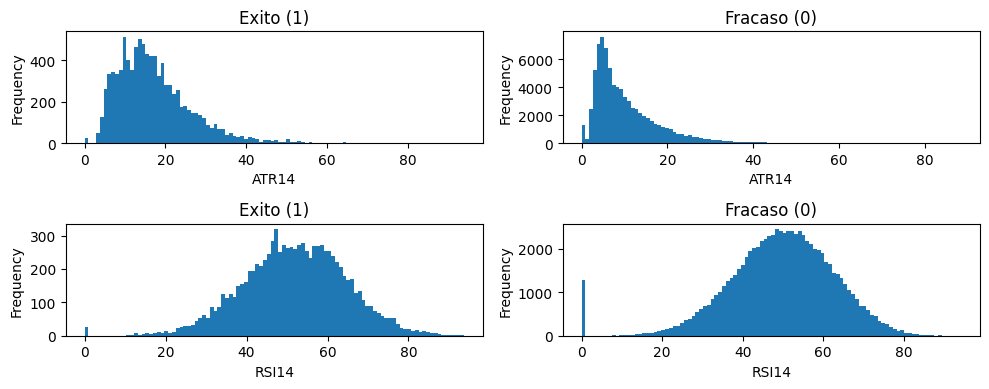

In [15]:
fig,ax=plt.subplots(2,2,figsize=(10,4))
Unos=Buys[Buys['Tres']==1]['ATR14'].plot(kind='hist',bins=100,ax=ax[0,0])
ax[0,0].set_title('Exito (1)')
ax[0,0].set_xlabel('ATR14')
Ceros=Buys[Buys['Tres']==0]['ATR14'].plot(kind='hist',bins=100,ax=ax[0,1])
ax[0,1].set_title('Fracaso (0)')
ax[0,1].set_xlabel('ATR14')
Unos=Buys[Buys['Tres']==1]['RSI14'].plot(kind='hist',bins=100,ax=ax[1,0])
ax[1,0].set_title('Exito (1)')
ax[1,0].set_xlabel('RSI14')
Ceros=Buys[Buys['Tres']==0]['RSI14'].plot(kind='hist',bins=100,ax=ax[1,1])
ax[1,1].set_title('Fracaso (0)')
ax[1,1].set_xlabel('RSI14')
plt.tight_layout()
plt.show()

Agregamos máximos y minimos

In [32]:
def agregar_max_min(df, n):
    """
    Agrega las columnas 'maximo' y 'minimo' al DataFrame.
    
    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas ['open', 'high', 'low', 'close'].
    - n (int): Número de observaciones anteriores y posteriores a considerar.
    
    Retorna:
    - pd.DataFrame: DataFrame original con las columnas 'maximo' y 'minimo' agregadas.
    """
    # Asegurarse de que el DataFrame está ordenado correctamente (opcional)
    # df = df.sort_index()

    # Calcular el máximo en una ventana de 2n+1 centrada en cada observación
    rolling_max = df['high'].rolling(window=2*n+1, center=True).max()
    # Asignar 1 si el 'high' actual es igual al máximo de la ventana, de lo contrario 0
    df['maximo'] = (df['high'] == rolling_max).astype(int)
    
    # Calcular el mínimo en una ventana de 2n+1 centrada en cada observación
    rolling_min = df['low'].rolling(window=2*n+1, center=True).min()
    # Asignar 1 si el 'low' actual es igual al mínimo de la ventana, de lo contrario 0
    df['minimo'] = (df['low'] == rolling_min).astype(int)
    
    # Opcional: Reemplazar NaN en las primeras y últimas n filas con 0
    df['maximo'] = df['maximo'].fillna(0).astype(int)
    df['minimo'] = df['minimo'].fillna(0).astype(int)
    
    return df

Buys=agregar_max_min(Buys,4)
Sells=agregar_max_min(Sells,4)

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

hola=agregar_max_min(data[data['DayOfYear']==138].copy(),4)

# Crear la figura con subplots
fig = make_subplots(rows=1, cols=1)

# Añadir gráfico de velas
fig.add_trace(go.Candlestick(
    x=hola.index,
    open=hola['open'],
    high=hola['high'],
    low=hola['low'],
    close=hola['close'],
    name='Candlesticks'
))
# Añadir los puntos para los máximos
fig.add_trace(go.Scatter(
    x=hola.index[hola['maximo'] == 1],  # Filtrar donde maximo es 1
    y=hola['high'][hola['maximo'] == 1],  # Usar los valores high correspondientes
    mode='markers',
    marker=dict(color='red', size=8),  # Puntos rojos
    name='Maximos'
))

# Añadir los puntos para los mínimos
fig.add_trace(go.Scatter(
    x=hola.index[hola['minimo'] == 1],  # Filtrar donde minimo es 1
    y=hola['low'][hola['minimo'] == 1],  # Usar los valores low correspondientes
    mode='markers',
    marker=dict(color='blue', size=8),  # Puntos azules
    name='Minimos'
))
# Actualizar layout
fig.update_layout(
    title=f"Operaciones del día x",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False
)

In [34]:
Buys.to_csv('Buys_t.csv', index=False)#Guardamos los datos en un archivo csv
Sells.to_csv('Sells_t.csv', index=False)